***
## [November 2018] - Spatial mapping of the beam profile
### Abstract:

By closing down the mono baffles to a small aperture and raster scanning tihs across the beam, it's possible to construct a 2D image of the beam profile at the mono baffles.

If instead of just measuring the diode current at each point you also record a monochromator energy scan, you can build an energy resolved beam profile as a 3D matrix.

For select undulator gaps, these meaurements can be simulated using SPECTRA. In general the agreement seems quite good.

Notes:
 - You are sampling the beam profile at the mono baffle position, but that light still has to be able to pass through the rest of the beamline to reach the diode. So if you see a truncated or asymmetric profile, you can't necessarily assume that it must be coming from M1 or the frontend.
 - The beam profile is magnified by the time it reaches the M4 diode. Under some circumstances it is necessary to move the diode at the same time as the mono baffle aperture to avoid falling off it.


***

**Mono baffle definitions:**

<img src="images/monoBaffles.jpg" width="500px"/>

Horizontal gap refers to the slit with a horizontal long axis. The gap itself is in the vertical direction!

***This means that scanning the horizontal offset maps the beam profile in the vertical direction***

In [1]:
from BLOCH_beamline import *
import matplotlib.patches as patches
from ipywidgets import interactive
from matplotlib.widgets import Slider
from IPython.display import display
from ipywidgets import *

data_folder = Path('Data/')

%matplotlib inline
font = {'size'   : 14}
matplotlib.rc('font', **font)

---- BLOCH beamline ----
	Last updated 02.13.2018 

	Latest change: Simple resolution calculators



## Measurement details

|Electrometer channel|Measurement|
|-|-|
| b110a_ctl_em02_ch03 |Current at the M4 photodiode|

|Beamline parameter | Setting |
|-|-|
| Ring current | 200mA|
| EPU (gap, phase) | (50, 0)
| Mono baffle gap (h, v) | (3.5,4.0) (=0.5x0.5)|
| Mono baffle offset (h, v) | scanned|


| Filename | Entry | Mono baffle offset (h, v) | Energy |
|-|-|-|-|
|undu_mono_scan5.h5| 1445 | (-6,-6) step 1 | 78..92|

```
ascan( monobaff hoffset ,-6,6,13,1)
    ascan( monobaff v offset,-6,6,13,1)
        ascan( monoenergy,78,92,120)
```

| Filename | Entry | Mono baffle offset (h, v) | Energy |
|-|-|-|-|
|undu_mono400_baf_scan1.h5| 1704..1730 | (-6,-6) | 400 |
|undu_mono500_baf_scan1.h5| 1731..1757 | (-6,-6) | 500 |
|undu_mono600_baf_scan1.h5| 1758..1784 | (-6,-6) | 600 |
|undu_mono700_baf_scan1.h5| 1785..1811 | (-6,-6) | 700 |
|undu_mono800_baf_scan1.h5| 1812..1838 | (-6,-6) | 800 |
|undu_mono900_baf_scan1.h5| 1839..1866 | (-6,-6) | 900 |

***
## Calculation details

| Parameter | Value |
|-|-|
|Program | SPECTRA 10.1|
|Mode | Near field>spatial dependence>spatial flux density> xy mesh|
|Field data|Gap50_HP_BxBy_Scan7c.txt|
|Parameter file |84.prm\*|

\*current reduced to 200mA

| folder| image (.dta) | EPU gap | Source distance | Energy | Comment |
|-|-|-|-|-|-|
|balu| balu-1 .. balu-121 | 50mm| 14m | 80-90 | |

***
## Local functions

In [10]:
#*****************************************************
def getIndexOfEnergy(energy):
#*****************************************************
    scan = HDF5loadscan(data_folder/"undu_mono_scan5.h5",1445)
    value = energy
    n = [abs(i-value) for i in scan['mono_energy']]
    print(len(n))
    idx = n.index(min(n))
    return idx

#*****************************************************
def buildEnergySlice(experimentMatrix,calculationMatrix,sliceEnergy,sliceOffset):
#*****************************************************
    experimentIndex=getIndexOfEnergy(sliceEnergy)
    calculationIndex=experimentIndex+sliceOffset
    
    fig=plt.figure(figsize=(10,5))
    
    plt.subplot(1, 2, 1)
    experimentImage=experimentMatrix[:,:,experimentIndex]
    plt.imshow(experimentImage,origin='lower',aspect='1',cmap='gray_r',extent=[-6,7,-6,6])
    plt.xlim([-6,6])
    plt.xlabel('Horizontal (mm)\n(v_offset)')
    plt.ylabel('Vertical (mm)\n(h_offset)')
    plt.title("Experiment (hv = {}eV)".format(sliceEnergy))
    plt.subplot(1, 2, 2)
    
    calculationImage=calculationMatrix[:,:,calculationIndex]
    plt.imshow(calculationImage,origin='lower',aspect='1',cmap='gray_r',extent=[-6,6,6,-6])
    plt.title("SPECTRA calculation")
    plt.xlabel('Horizontal (mm)')
    plt.ylabel('Vertical (mm)')
    plt.tight_layout()
    
#*****************************************************
def ShowImage(experimentMatrix,calculationMatrix,minEnergy,maxEnergy):
#*****************************************************   
    sliceNumberSlider=widgets.FloatSlider(
        value=86.5,
        min=minEnergy,
        max=maxEnergy,
        description='Energy:',
        continuous_update=False,
        layout=Layout(width='600px')
    )    
    sliceOffsetSlider=widgets.IntSlider(
        value=0,
        min=-30,
        max=30,
        description='sliceOffset:',
        continuous_update=False,
        layout=Layout(width='600px')
    )   
           
    w = interactive(
        buildEnergySlice,
        experimentMatrix=fixed(experimentMatrix),
        calculationMatrix=fixed(calculationMatrix),
        sliceEnergy=sliceNumberSlider,
        sliceOffset=sliceOffsetSlider
    )
   
    # prevent flicker as the cell size goes to zero when redrawing
    output = w.children[-1]
    output.layout.height = '500px'
    return w 

***
## Load calculation results:

In [3]:
calculation_folder = Path('SPECTRA_calculations/balu')

imageSet=range(1,122) 
calculatedMatrix=np.zeros((30,30,121))
    
for imgNumber in imageSet:
    img,imgextent=loadSPECTRA_image(calculation_folder/"balu-{0}.dta".format(imgNumber)) 
    calculatedMatrix[:,:,imgNumber-1]=img[:,:]

***
## Load experimental data:

In [4]:
entryNumber = 1445
experimentalMatrix=np.zeros((13,14,121))


for rowIndex,row in enumerate(range(-6,7,1)): #h offset (vertical beam profiling) 
    for columnIndex,column in enumerate(range(-6,8,1)): #v offset (horizontal beam profiling)

        scan = HDF5loadscan(data_folder/"undu_mono_scan5.h5",entryNumber)
        scan['diodeCurrent'] = [((ii*-1)/1000) for ii in scan['b110a_ctl_em02_ch03']]
        scan['flux'] = [currentToFlux(I,hv) for I,hv in zip(scan['diodeCurrent'],scan['mono_energy'])]
        experimentalMatrix[rowIndex][columnIndex][:] = scan['flux']

        entryNumber+=1
    
    entryNumber+=1


In [11]:
ShowImage(experimentalMatrix,calculatedMatrix,78,92)

A Jupyter Widget

The orientation here is as if you were in the mono looking towards the EPU

According to this, to center the baffles on the beam one should use (h_offset,v_offset) = (0,1)

***
## Experimental data at fixed energies

Note that here the experimental data was taken at 19mm, but the simulations were done at 20mm (We only have magnetic field data for 14,15,16,20,30,50,180)

In [7]:
#***************************************************
def loadExperimentImage(path,energy,firstScanNumber):
#***************************************************
    loadedImage=np.zeros((26,26))
    entryNumber = firstScanNumber
    for rowIndex in range(26):
        scan = HDF5loadscan(path,entryNumber)
        scan['diodeCurrent'] = [((ii*-1)/1000) for ii in scan['b110a_ctl_em02_ch03']]
        scan['mono_energy'] = [(energy) for ii in scan['b110a_ctl_em02_ch03']]
        scan['flux'] = [currentToFlux(I,hv) for I,hv in zip(scan['diodeCurrent'],scan['mono_energy'])]
        loadedImage[:][rowIndex] = scan['flux']
        entryNumber+=1

    return loadedImage

#***************************************************
def showImages(experimentImage,calculationImage,title):
#***************************************************
    fig=plt.figure(figsize=(10,5))
    fig.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.imshow(experimentImage,aspect='1',cmap='gray_r',extent=[-6,6,-6,6])
    plt.xlabel('Horizontal (mm)')
    plt.ylabel('Vertical (mm)')
    plt.title("Experiment")

    plt.subplot(1, 2, 2)
    plt.imshow(calculationImage,aspect='1',cmap='gray_r',extent=calculationImageExtent)
    plt.xlim=([-6,6]),
    plt.ylabel('Vertical (mm)')
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)

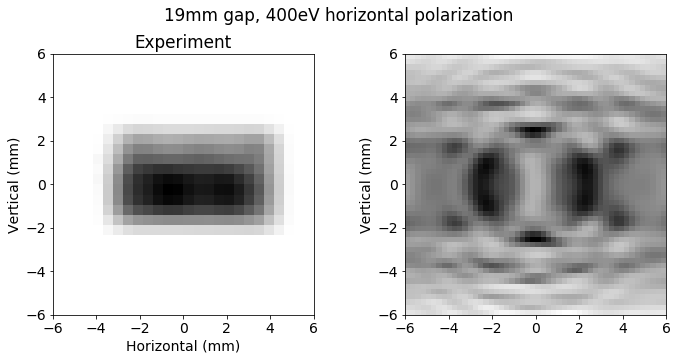

In [8]:
experimentImage=loadExperimentImage(data_folder/"undu_mono400_baf_scan1.h5",400,1704)
calculation_folder = Path('SPECTRA_calculations/baluFixed')
calculationImage,calculationImageExtent=loadSPECTRA_image(calculation_folder/"400.dta")

showImages(experimentImage,calculationImage,'19mm gap, 400eV horizontal polarization')

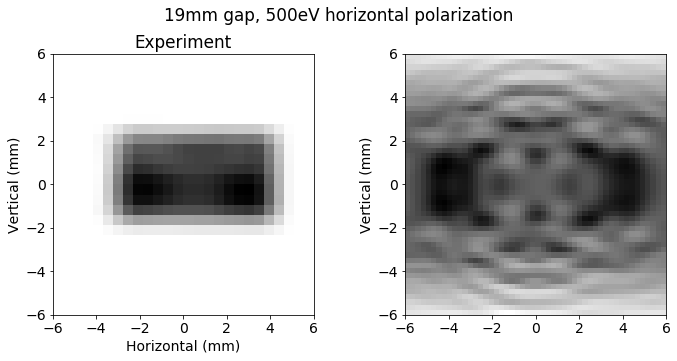

In [9]:
experimentImage=loadExperimentImage(data_folder/"undu_mono500_baf_scan1.h5",500,1731)
calculation_folder = Path('SPECTRA_calculations/baluFixed')
calculationImage,calculationImageExtent=loadSPECTRA_image(calculation_folder/"500.dta")

showImages(experimentImage,calculationImage,'19mm gap, 500eV horizontal polarization')

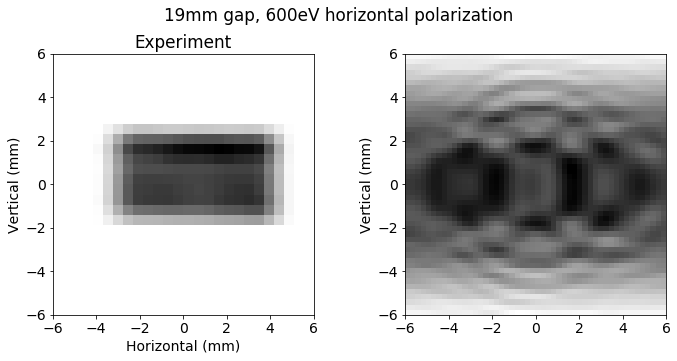

In [10]:
experimentImage=loadExperimentImage(data_folder/"undu_mono600_baf_scan1.h5",600,1758)
calculation_folder = Path('SPECTRA_calculations/baluFixed')
calculationImage,calculationImageExtent=loadSPECTRA_image(calculation_folder/"600.dta")

showImages(experimentImage,calculationImage,'19mm gap, 600eV horizontal polarization')

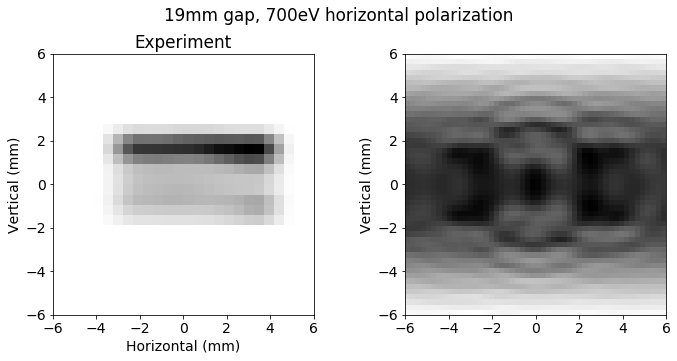

In [11]:
experimentImage=loadExperimentImage(data_folder/"undu_mono700_baf_scan1.h5",700,1785)
calculation_folder = Path('SPECTRA_calculations/baluFixed')
calculationImage,calculationImageExtent=loadSPECTRA_image(calculation_folder/"700.dta")

showImages(experimentImage,calculationImage,'19mm gap, 700eV horizontal polarization')

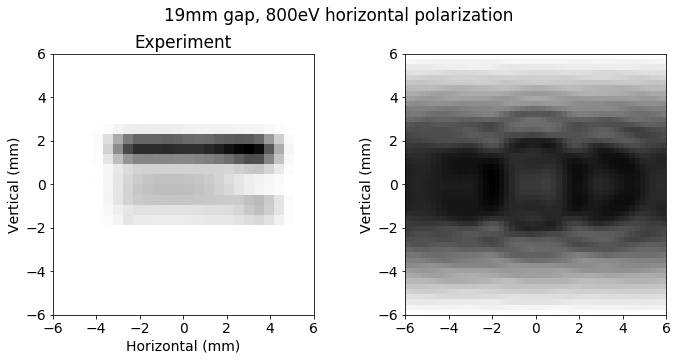

In [26]:
experimentImage=loadExperimentImage(data_folder/"undu_mono800_baf_scan1.h5",800,1812)
calculation_folder = Path('SPECTRA_calculations/baluFixed')
calculationImage,calculationImageExtent=loadSPECTRA_image(calculation_folder/"800.dta")

showImages(experimentImage,calculationImage,'19mm gap, 800eV horizontal polarization')

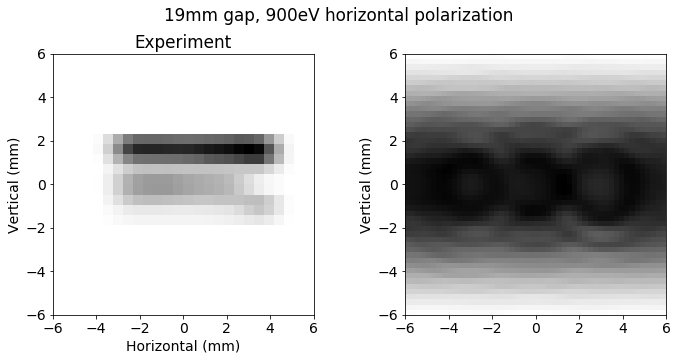

In [27]:
experimentImage=loadExperimentImage(data_folder/"undu_mono900_baf_scan1.h5",900,1839)
calculation_folder = Path('SPECTRA_calculations/baluFixed')
calculationImage,calculationImageExtent=loadSPECTRA_image(calculation_folder/"900.dta")

showImages(experimentImage,calculationImage,'19mm gap, 900eV horizontal polarization')

Looks like something is not right with the alignment as we go to progressively higher energies.

***
## Circular polarization test

Balu measured this one, moving the diode as during the measurement.

In [13]:
def loadScan(entryNumber):
    scan = HDF5loadscan(data_folder/"cp20d.h5",entryNumber)
    scan['diodeCurrent'] = [((ii*-1)/1000) for ii in scan['b110a_ctl_em02_ch03']]
    return scan

In [14]:
entryNumber = 2516
experimentalMatrix=np.zeros((61,61))

for rowIndex in range(0,60): #h offset (vertical beam profiling) 
        if entryNumber+rowIndex<2571:
            scan = loadScan(entryNumber+rowIndex)
            experimentalMatrix[rowIndex][:] = scan['diodeCurrent']


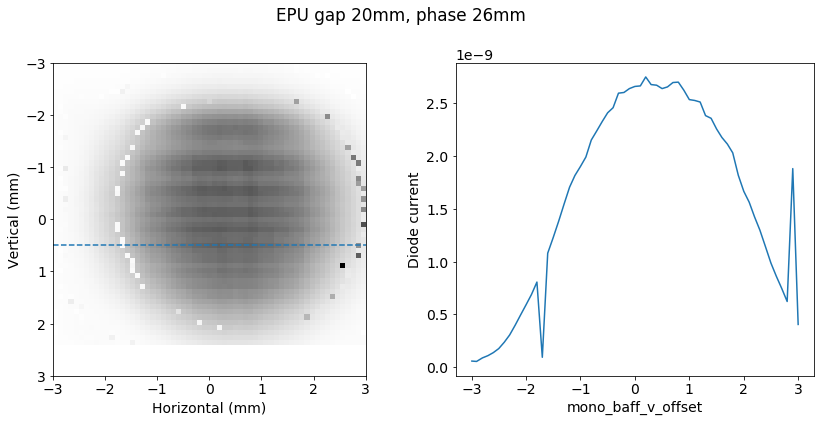

In [15]:
fig=plt.figure(figsize=(12,6))
plt.suptitle("EPU gap 20mm, phase 26mm")
plt.subplot(1,2,1)
plt.imshow(experimentalMatrix,aspect='1',cmap='gray_r',extent=[-3,3,3,-3])
plt.plot([-3,3],[0.5,0.5],linestyle='--')
plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')

plt.subplot(1,2,2)
scan = loadScan(2551)
plt.plot(scan['mono_baff_v_offset'],scan['diodeCurrent'])
plt.ylabel('Diode current')
plt.xlabel('mono_baff_v_offset')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

Many questions here. The horizontal banding is probably an artifact from a non-uniform diode response. I am at a total loss to explain the sharp dips and peaks around the circumference of the beam.